**GRUPO 19: Federico Arias Ceci, Lucia Gatica y Trangoni Enzo**

**<h1>Práctica computacional: modelo de Ising en 2D</h1>**

El objetivo de la práctica es calcular varios observables (magnetización, energía, susceptibilidad, calor específico) de una red de Ising bidimensional en función de la temperatura. También calcularemos la función de correlación y estudiaremos la dependencia de la longitud de correlación con la temperatura. Usaremos unidades en las que $J=k=1$.

Más precisamente, el objetivo es ver cómo, si $T\approx 2.27$ y si la red es lo suficientemente grande, los observables tienen un comportamiento *abrupto*. En una red finita, no esperamos encontrar una transición de fase, pero los experimentos con redes finitas deben apuntar en esa dirección.

Es posible calcular la función de partición exacta para redes de hasta unos cientos de espines por lado. Para una red de $512 \times 512$ espines se necesitan unos 8 GB de memoria para guardar la función de partición. Desde un punto de vista práctico, las cosas rápidamente se vuelven inmanejables. Sin embargo, los experimentos numéricos pueden llegar mucho más allá de una red de $512 \times 512$. En lugar de calcular la función de partición exacta, lo que hacemos es generar estados aleatorios de la red distribuidos según el ensamble canónico, y tomar promedios sobre varios de esos estados. Para lograr eso, partimos de un estado inicial cualquiera y le aplicamos el **algoritmo de Metropolis**, que consta de los siguientes pasos:

1.   Elegimos un sitio de la red al azar.
2.   Calculamos la diferencia de energía $\Delta E$ que resultaría de dar vuelta a ese espín.
3. Si $\Delta E\le 0$, le damos vuelta al espín; si $\Delta E>0$, le damos vuelta al espín con probabilidad $e^{-\beta\Delta E}$.

Al estado resultante le volvemos a aplicar el algoritmo, y así sucesivamente. Después de ser iterado muchas veces, el algoritmo empieza a generar estados distribuidos según el ensamble canónico. Tomando promedios sobre varios de esos estados, podremos calcular los observables de interés.

La práctica tiene en cuenta la finitud de la vida humana, así que el objetivo no es hacer experimentos con redes desmesuradamente grandes.

Un consejo, para que administren su tiempo. Pueden usar la biblioteca **tqdm** para mostrar barras de progreso. Como muestra la celda de abajo.

# Bibliotecas

Importamos las bibliotecas de Python que vamos a usar: numpy, que permite definir y operar con matrices, genera números aleatorios, incluye todo tipo de funciones matemáticas, etc.; matplotlib.pyplot, que permite hacer gráficos; y numba, que es un compilador que hace que las funciones corran mucho más rápido. También importamos la función curve_fit del paquete scipy.optimize, que nos servirá para hacer ajustes.

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from numba import njit
import pandas as pd

mpl.rcParams["figure.autolayout"] = True
mpl.rcParams["figure.figsize"] = (10,6)
mpl.rcParams["font.size"] = 12
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["axes.grid"] = True
mpl.rcParams['axes.labelsize'] = 12


# Funciones

Aquí van a tener que definir dos funciones. La primera, **`h(S)`**, calcula la energía por partícula de la red en el estado **`S`** (nótese que **`S`** es una matriz de unos y menos unos). Asumimos que no hay campo magnético y usamos condiciones de contorno periódicas, de manera que el primer espín de una fila/columna es vecino del último. Si la red es $L\times L$, la energía total es entonces

$$H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1}),$$

y la energía por partícula es esto dividido por $L^2$. La segunda función que tienen que definir,  **`metropolis(S,prob)`**, aplica el algoritmo de Metropolis al estado **`S`** y devuelve tres cosas: un nuevo estado **`S`**, el incremento de magnetización **`dm`** y el incremento de energía por partícula **`de`**. Deben notar que los únicos valores positivos que puede tomar el incremento de energía $\Delta E$ resultante de dar vuelta a un espín son $\Delta E=4$ y $\Delta E=8$; el argumento **`prob`** es un vector de dos componentes, **`prob[0]`** y **`prob[1]`**, que son las probabilidades con las que daremos vuelta al espín si el incremento de energía es $4$ y $8$ respectivamente. Algunos consejos:


*   Para implementar las condiciones de contorno periódicas, conviene recordar que las listas de Python empiezan con el elemento $0$. Si la red tiene lado $L$, el último elemento es el $L - 1$. Alternativamente,  el elemento $-1$ es el último, el $-2$ el penúltimo, etc. También les va a ser útil la función **`%`**, que calcula el resto de la división entre dos enteros (es decir, **`m%n`** es el resto de la división entre **`m`** y **`n`**). Esto es útil para implementar las condiciones de contorno periódicas sin tener que tratar de manera distinta a los espines que están en los bordes de la red.
*   ¡Sean económicos! Para calcular $\Delta E$ no deben calcular la energía total de los dos estados (el estado original y el estado con el espín seleccionado dado vuelta) y restar, sino darse cuenta de que esta cantidad sólo involucra al estado del espín seleccionado y el de sus cuatro primeros vecinos.
*   Para dar vuelta a un espín con probabilidad $p$, lo que hacemos es generar un número aleatorio entre $0$ y $1$ y dar vuelta el espín si ese número es menor que $p$.

Una vez hayan definido estas funciones, primero de todo asegúrense de que andan bien probándolas con una matriz $3\times 3$, por ejemplo, tomando **`S=np.ones((3,3))`**. Ahí pueden calcular a mano la energía por partícula y chequear que **`h(S)`** da el resultado correcto. También pueden asegurarse de que, partiendo de esta misma matriz, la funcion **`metropolis(S,prob)`** da vuelta a algún espín más fácilmente a temperaturas altas que a temperaturas bajas, y que los incrementos de magnetización y energía por partícula que calcula son los correctos. Una vez hayan hecho eso, redefinan la función **`metropolis(S,prob)`** de manera que aplique el algoritmo de Metropolis no una sola vez sino tantas como sitios tiene la red. Es decir, su función definitiva debería aplicar el algoritmo al estado original, y después volvérselo a aplicar al estado resultante, y así tantas veces como sitios tiene la red. De vuelta, comprueben que esta función anda bien con una matriz sencilla. El proceso de repetir el algoritmo elemental $L \times L$ veces es lo que se llama **un paso** de Montecarlo.

In [ ]:
@njit
def h(S) -> int:
  E = 0
  for i in range(-1,S.shape[0]-1):
    for j in range(-1,S.shape[1]-1):
      E += -S[i,j]*((S[i-1,j])+(S[i,j-1])+(S[i+1,j])+(S[i,j+1]))
      #Calcula la energia por particula (aprovecho la numeración de numpy para no tener problemas con los extremos de las listas)
  return E/(2*S.size)

@njit
def metropolis(S,prob): #Aplica el algoritmo de Metropolis al estado S

  dm = 0
  de = 0

  Cord_ss = np.random.randint(low=0, high=S.shape[0],size = (S.size,2))
  Cord_ss = Cord_ss - np.full((S.size, 2), 1)

  for cord_ss in Cord_ss: #Aplicamos el algoritmo L veces
    ss = S[cord_ss[0], cord_ss[1]] #Seleccionamos el spin

    d_e = 2*ss*(S[cord_ss[0]-1,cord_ss[1]] + S[cord_ss[0],cord_ss[1]-1] + S[cord_ss[0]+1,cord_ss[1]] + S[cord_ss[0],cord_ss[1]+1]) #Calculamos el efecto en la energía de dar vuelta el spin

    p = int(d_e/4 - 1)
    p = prob[p]

    if d_e > 0:
        if np.random.rand() < p:
          S[cord_ss[0],cord_ss[1]] = -ss
          d_m = -2 * ss / S.size
          d_e /= S.size
        else:
          d_m = 0
          d_e = 0
    else:
        S[cord_ss[0],cord_ss[1]] = -ss
        d_m = -2 * ss / S.size
        d_e /= S.size

    dm += d_m
    de += d_e

  return S,dm,de

En esta celda lo que se hizo fue definir las función **h(s)** que calcula la energía del sistema por espin. Para esto simplemente se calculó la energía total siguiendo la ecuación $$H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1}),$$ y se dividió por el tamaño de la red.

Por otra parte, también definió la función **metrópolis**, que aplica el algoritmo metrópolis $L^{2}$ veces al sistema de forma que aplicando esta funcion una cierta cantidad de veces, se tienda a un ensamble canónico. Esta función también determina la nueva matriz **S**, y las diferencias de magnetización y energía al haber aplicado el algoritmo de metrópolis.




# Termalización

Partiendo de un cierto estado inicial, estudiamos cuántos pasos son necesarios para que el sistema llegue al equilibrio, es decir, para que los distintos estados empiecen a estar distribuidos según el ensamble canónico. Para eso, graficamos la magnetización y la energía por partícula en función del paso; el equilibrio se alcanza cuando estas cantidades empiezan a fluctuar alrededor de un valor fijo, en lugar de ser netamente crecientes o decrecientes.
El número de pasos necesarios para alcanzar el equilibrio dependerá de la temperatura, así que hay que hay que hacer el análisis para varias temperaturas. También puede depender del lado de la red, así que cuando cambien el valor de este parámetro van a tener que rehacer este análisis. Fíjense que, cerca de la temperatura crítica, la magnetización oscila entre $1$ y $-1$.

100%|██████████| 99999/99999 [00:03<00:00, 26284.46it/s]


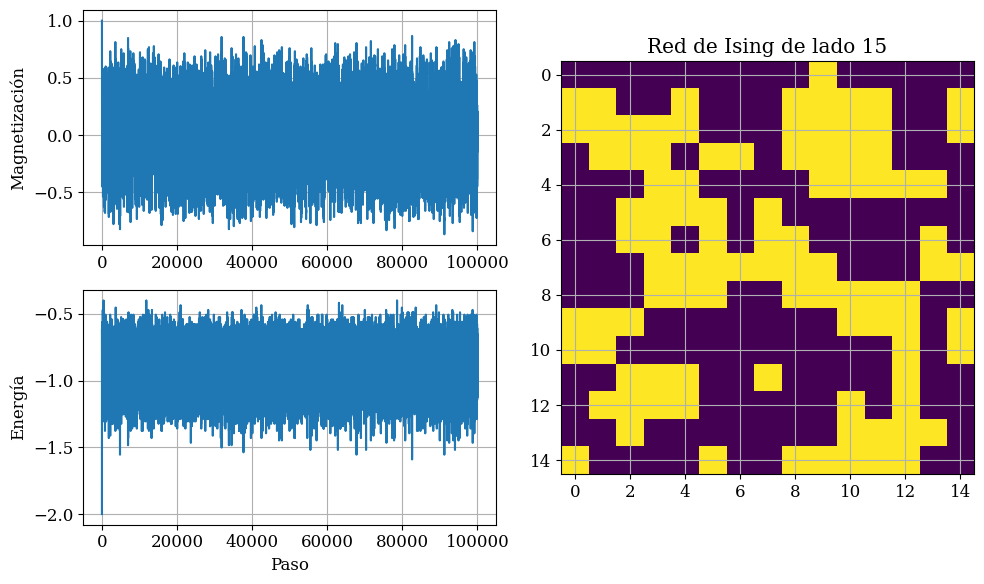

100%|██████████| 99999/99999 [00:10<00:00, 9347.33it/s] 


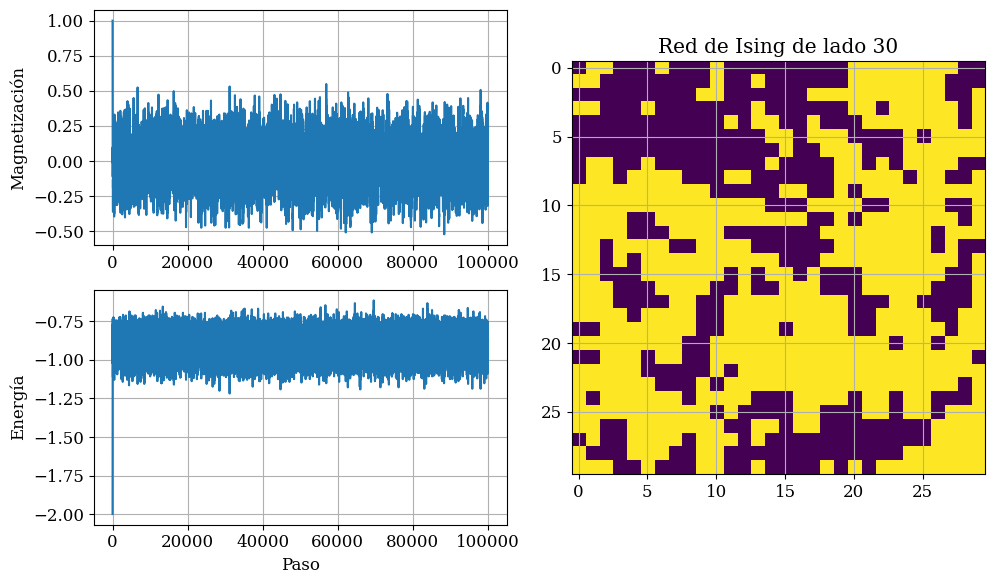

100%|██████████| 99999/99999 [00:41<00:00, 2424.76it/s]


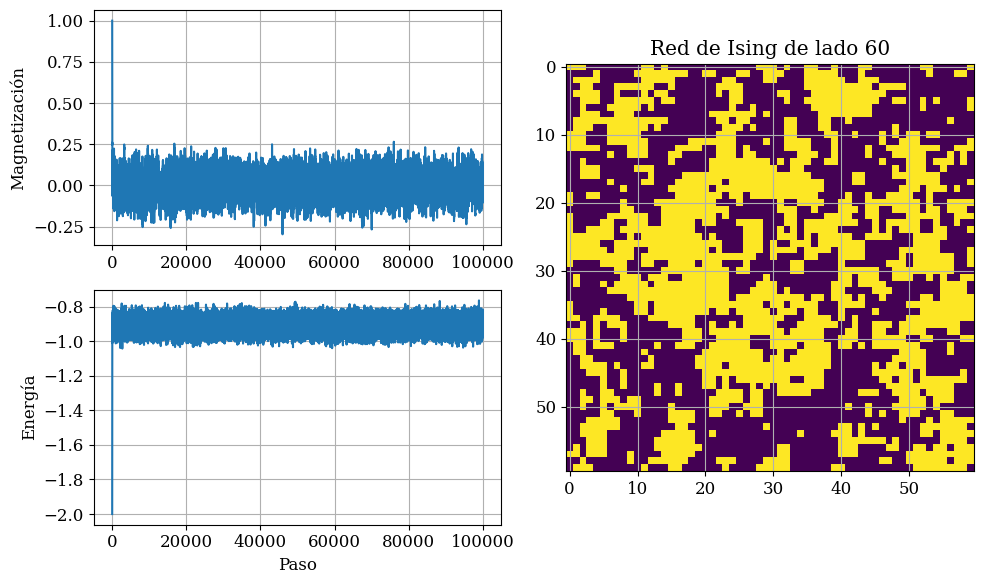

In [ ]:
beta=1/2.8 #beta = 1/T => la temperatura es T = 1/beta
for L in [15, 30, 60]:
  np.random.seed(20)

  nequilibrio=100000 #Numero de pasos (de Montecarlo) tentativo para llegar al equilibrio

  prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

  #Estado inicial
  #Opcion 1: todos los spines apuntan para arriba
  S=np.ones((L,L),dtype=int)
  #Opcion 2: matriz aleatoria de 1's y -1's
  #S=2*np.random.randint(2,size=(L,L))-1

  m=np.zeros(nequilibrio) #magnetización en función del paso
  e=np.zeros(nequilibrio) #energia por particula en funcion del paso
  m[0]=np.mean(S)
  e[0]=h(S)

  for n in tqdm(range(1,nequilibrio)):
    S,dm,de=metropolis(S,prob)
    m[n]=m[n-1]+dm
    e[n]=e[n-1]+de

  plt.figure()
  plt.subplot(2,2,1)
  plt.plot(m)
  plt.ylabel('Magnetización')
  plt.subplot(2,2,3)
  plt.plot(e)
  plt.ylabel('Energía')
  plt.xlabel('Paso')
  plt.subplot(1,2,2)
  plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
  plt.title(f'Red de Ising de lado {L}')
  plt.show()

100%|██████████| 99999/99999 [02:38<00:00, 631.73it/s]


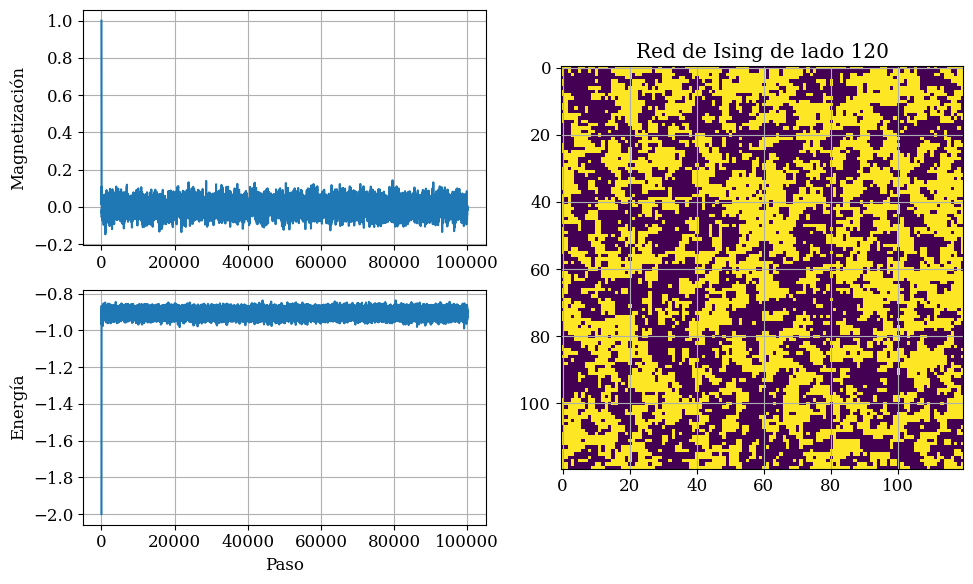

In [ ]:
L=120 #Lado de la red
beta=1/2.8 #beta = 1/T => la temperatura es T = 1/beta

np.random.seed(20)

nequilibrio=100000 #Numero de pasos (de Montecarlo) tentativo para llegar al equilibrio

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

#Estado inicial
#Opcion 1: todos los spines apuntan para arriba
S=np.ones((L,L),dtype=int)
#Opcion 2: matriz aleatoria de 1's y -1's
#S=2*np.random.randint(2,size=(L,L))-1

m=np.zeros(nequilibrio) #magnetización en función del paso
e=np.zeros(nequilibrio) #energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

for n in tqdm(range(1,nequilibrio)):
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm
  e[n]=e[n-1]+de

plt.figure()
plt.subplot(2,2,1)
plt.plot(m)
plt.ylabel('Magnetización')
plt.subplot(2,2,3)
plt.plot(e)
plt.ylabel('Energía')
plt.xlabel('Paso')
plt.subplot(1,2,2)
plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
plt.title(f'Red de Ising de lado {L}')
plt.show()

# plt.figure()
# plt.subplot(2,2,1)
# plt.plot(np.abs(m))
# plt.ylabel('magnetizacion')
# plt.xlabel('paso')
# plt.subplot(1,2,2)
# plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
# plt.show()


Vemos un problema en el grafico anterior, la magentización puede pasar a tomar valores negativos. ¿Es posible que, a pesar de tomar el módulo, los valores cercanos a cero afecten sensiblemente el promedio?

# Promedios

Estudiamos cuántos pasos hacen falta para calcular buenos promedios. Para eso, graficamos el valor medio de la magnetización y la energía por partícula en función del número de pasos utilizados para calcularlo (empezando a contar después de haber llegado al equilibrio). Cuando el valor medio se haga constante, el número de pasos será suficiente. De vuelta, el número de pasos apropiado depende de la temperatura y del lado de la red. Van a ver que, cerca de la temperatura crítica, las fluctuaciones se hacen más grandes y por lo tanto es necesario promediar sobre un número más grande de pasos. Para librarnos de las fluctuaciones de la magnetización entre $1$ y $-1$ cerca de la temperatura crítica, que son inmanejables, lo que tomamos es **el valor medio de su módulo**.

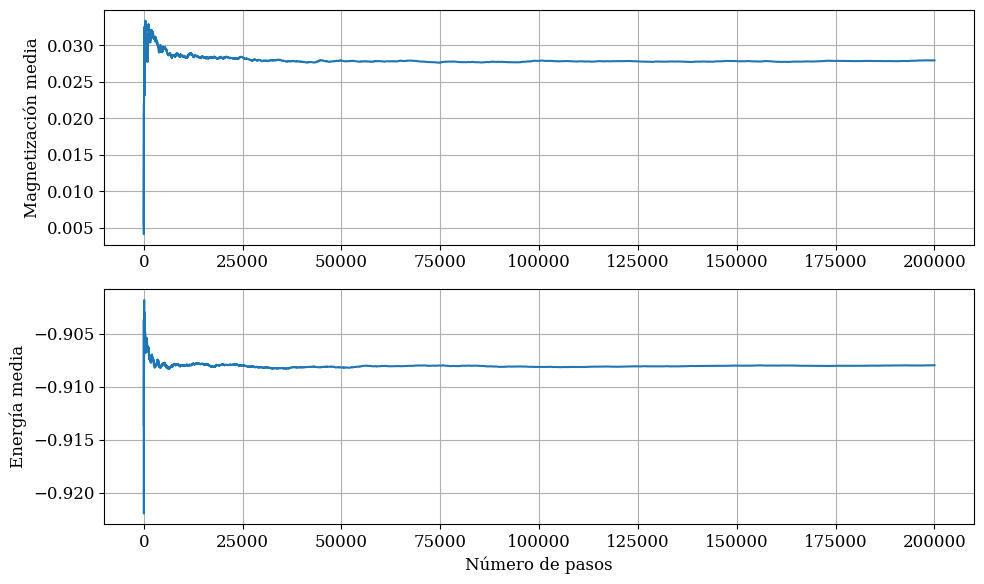

In [ ]:
L=120
beta=1/2.8

nequilibrio=200000 #Este valor lo decidimos en base a lo anterior
npromedio = nequilibrio #Numero de pasos tentativo para calcular promedios

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

S=np.ones((L,L),dtype=int) #Estado inicial

np.random.seed(20)

for n in range(nequilibrio):
  S,dm,de=metropolis(S,prob) #Termalizamos


m=np.zeros(npromedio)
e=np.zeros(npromedio) #Magnetizacion y energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

mmedia=[abs(m[0])]
emedia=[e[0]] #Valores medios en funcion del numero de pasos para promediar

for n in range(1,npromedio):
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm
  e[n]=e[n-1]+de
  mmedia.append(np.mean(abs(m[0:n+1])))
  emedia.append(np.mean(e[0:n+1]))

plt.figure()
plt.subplot(2,1,1)
plt.plot(mmedia)
plt.ylabel('Magnetización media')
plt.subplot(2,1,2)
plt.plot(emedia)
plt.ylabel('Energía media')
plt.xlabel('Número de pasos')
plt.show()

# Transición de fase

Aquí hay que calcular la magnetización media, la energía media por partícula, la susceptibilidad y el calor específico para varias temperaturas, graficar el resultado y ver que a una temperatura cercana a la crítica se produce un comportamiento casi brusco. Algunos consejos:

*   Para calcular la susceptibilidad y el calor específico no hay que tomar ninguna derivada, hay que usar la relación entre estas cantidades y la varianza de la magnetización y la energía por partícula respectivamente.
*   No propongan un nuevo estado inicial para cada temperatura: aprovechen el último estado de la temperatura anterior, porque así van a necesitar menos pasos para termalizar. Si empiezan a temperaturas bajas, conviene tomar como estado inicial la matriz de unos, y si empiezan a temperaturas altas conviene tomar como estado inicial una matriz aleatoria de unos y menos unos.
*   Conviene dar más pasos para termalizar y/o tomar promedios cerca de la temperatura crítica que lejos de ella.

Aquí se muestran unos gráficos tìpicos. El de la susceptibilidad puede mejorarse.

![tipicos](http://materias.df.uba.ar/ft3a2024c1/files/2024/06/tipicos.png)

In [ ]:
L=30 #Lado de la red

T =  np.concatenate((np.linspace(1.5,2,10),np.linspace(2,3,20),np.linspace(3,3.5,10)))

MAGNETIZACION = []
ENERGIA = []
CALOR_ESP = []
SUCEPTIBILIDAD = []


S=np.ones((L,L),dtype=int)

for beta in tqdm(1/T):

  prob = np.array([np.exp(-4*beta),np.exp(-8*beta)])

  m=[]
  e=[]

  m.append(np.mean(S))
  e.append(h(S))

  nequilibrio = int(100000*(np.exp(- (1/beta - 2.5)**2 *2)) // 1) #Voy a usar como referencia la cantidad de pasos que necesitamos para alcanzar el equilibrio en el entorno de la temperatura critica. Para otras temperaturas usare menos pasos para ahorrar tiempo

  for n in range(0,nequilibrio): #Termalizamos
      S,dm,de=metropolis(S,prob)

  m.append(np.mean(S))
  e.append(h(S))

  lim = nequilibrio

  for n in range(0,lim):
    S,dm,de=metropolis(S,prob)
    m.append(m[-1]+dm)
    e.append(e[-1]+de)

  M = np.mean(np.abs(m[-lim:]))
  E = np.mean(e[-lim:])
  C = np.var(e[-lim:])*beta**2*S.size
  X = np.var(np.abs(m[-lim:]))*beta*S.size

  MAGNETIZACION.append(M)
  ENERGIA.append(E)
  CALOR_ESP.append(C)
  SUCEPTIBILIDAD.append(X)

plt.subplot(2,2,1)
plt.scatter(T, MAGNETIZACION)
plt.ylabel('magnetizacion')
plt.title(f'Red de Ising de lado L ={L}')
plt.subplot(2,2,3)
plt.scatter(T, ENERGIA)
plt.ylabel('Energía')
plt.xlabel('Temperatura')
plt.subplot(2,2,2)
plt.scatter(T, CALOR_ESP)
plt.ylabel('Calor específico')
plt.subplot(2,2,4)
plt.scatter(T, SUCEPTIBILIDAD)
plt.ylabel('Susceptibilidad')
plt.xlabel('Temperatura')



  8%|▊         | 3/40 [00:09<01:56,  3.15s/it]

Acá lo que se hace es aplicar la función metrópolis **nequilibrio** veces para que termalice. Una vez termalizado se aplicó la función metrópolis **lim** veces considerando cada cambio, una copia del ensamble distinto, dado que una vez termalizado el ensamble se asemeja a uno canónico. Hecho esto **lim** veces, se calculó la magnetización y energía para cada paso, y luego se tomo un valor medio; también se calculó la susceptibilidad y calor específico utilizando que son proporcionales a la varianza de M y E:

$\chi = \beta \cdot L^{2} \cdot \left( \left \langle M^{2} \right\rangle -  \left\langle M \right\rangle^{2} \right)$

$C_{V} = \beta^{2} \cdot L^{2} \cdot \left( \left \langle E^{2} \right\rangle -  \left\langle E \right\rangle^{2} \right).$

Se realizó este procedimiento para diferentes temperaturas, para luego realizar un gráfico de las 4 magnitudes en función de la temperatura.

In [ ]:
CV_EX = pd.read_csv("/content/C_32x32 (1).csv") # Lee el CSV
columnascv = list(CV_EX.columns)
temp_cv = (CV_EX[columnascv[0]])
cv = (CV_EX[columnascv[1]])

ENERGIA_EX = pd.read_csv("/content/U_32x32 (1).csv") # Lee el CSV
columnasU = list(ENERGIA_EX.columns)
temp_U = (ENERGIA_EX[columnasU[0]])
U = (ENERGIA_EX[columnasU[1]])

100%|██████████| 40/40 [14:23<00:00, 21.60s/it]


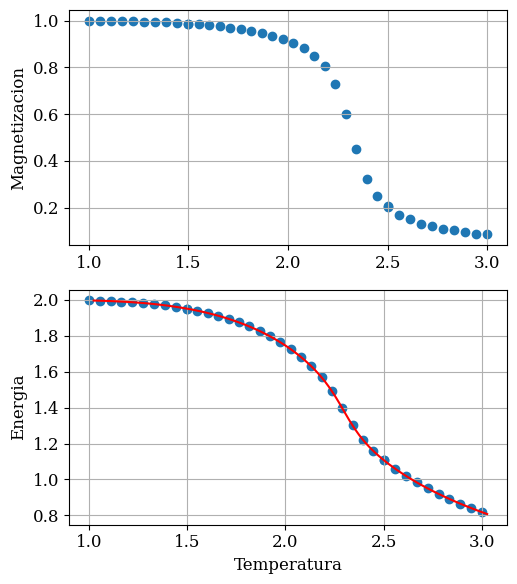

Text(0.5, 0, 'Temperatura')

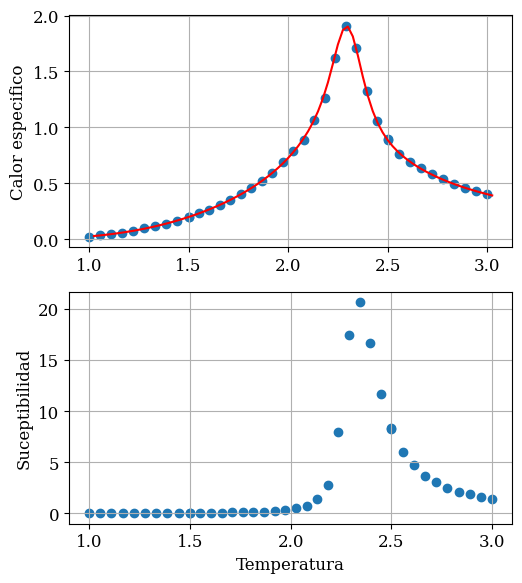

In [ ]:
L=32 #Lado de la red

T =  np.concatenate((np.linspace(1,1.5,10),np.linspace(1.5,2.5,20),np.linspace(2.5,3,10)))

MAGNETIZACION = []
ENERGIA = []
CALOR_ESP = []
SUCEPTIBILIDAD = []
 #Numero de pasos tentativo para llegar al equilibrio


for beta in tqdm(1/T):

  prob = np.array([np.exp(-4*beta),np.exp(-8*beta)])

  m=[]
  e=[]

  S=np.ones((L,L),dtype=int)
  m.append(np.mean(S))
  e.append(h(S))

  np.random.seed(0)

  nequilibrio = int(200000*(np.exp(- (1/beta - 2.5)**2 *2)) // 1) #Voy a usar como referencia la cantidad de pasos que necesitamos para alcanzar el equilibrio en el entorno de la temperatura critica. Para otras temperaturas usare menos pasos para ahorrar tiempo

  for n in range(0,nequilibrio): #Termalizamos
      S,dm,de=metropolis(S,prob)

  m.append(np.mean(S))
  e.append(h(S))

  lim = nequilibrio

  for n in range(0,lim):
    S,dm,de=metropolis(S,prob)
    m.append(m[-1]+dm)
    e.append(e[-1]+de)

  M = np.mean(np.abs(m[-lim:]))
  E = np.mean(e[-lim:])
  C = np.var(e[-lim:])*beta**2*S.size
  X = np.var(np.abs(m[-lim:]))*beta*S.size

  MAGNETIZACION.append(M)
  ENERGIA.append(E)
  CALOR_ESP.append(C)
  SUCEPTIBILIDAD.append(X)



plt.subplot(2,2,1)
plt.scatter(T, MAGNETIZACION)
plt.ylabel('Magnetizacion')
plt.subplot(2,2,3)
plt.scatter(T, -np.array(ENERGIA))
plt.plot(temp_U[39:120], U[39:120], color = 'red')
plt.ylabel('Energia')
plt.xlabel('Temperatura')
plt.show()

plt.subplot(2,2,2)
plt.scatter(T, CALOR_ESP)
plt.plot(temp_cv[39:120], cv[39:120], color = 'red')
plt.ylabel('Calor especifico')
plt.subplot(2,2,4)
plt.scatter(T, SUCEPTIBILIDAD)
plt.ylabel('Suceptibilidad')
plt.xlabel('Temperatura')

Para estar seguros de que están haciendo las cosas bien, [aquí](https://drive.google.com/file/d/1sfsT2yqvdG0YHFHTcoAdrXIpef6EMv9R/view?usp=drive_link) pueden bajar el calor específico por partícula  como función de la temperatura, calculado exactamente, para la red de 32x32, y [aquí](https://drive.google.com/file/d/1zSnolG_9DMnR-k_ZillLK4VAz2N33Ztv/view?usp=drive_link) la energía media. Los archivos son dos tablas en formato .csv con resultados numéricos obtenidos a partir de la función de partición exacta. Hagan dos gráficos que muestren sus resultados experimentales comparados con las curvas teóricas. Acoten el rango de valores del eje horizontal al rango de valores experimentales. Como la red es pequeña, tiene que haber poquísimo ruido (miren la figura 16.1 de la última edición del libro de Pathria & Beale). [Aquí](https://drive.google.com/drive/folders/1qh0loWq7viENgYd0ssUEx_bLi-s-LlZC?usp=drive_link) pueden bajar los datos exactos para otras redes.
![pathria_16_1](http://materias.df.uba.ar/ft3a2024c1/files/2024/06/pathria_16_1.png)

100%|██████████| 40/40 [15:25<00:00, 23.13s/it]


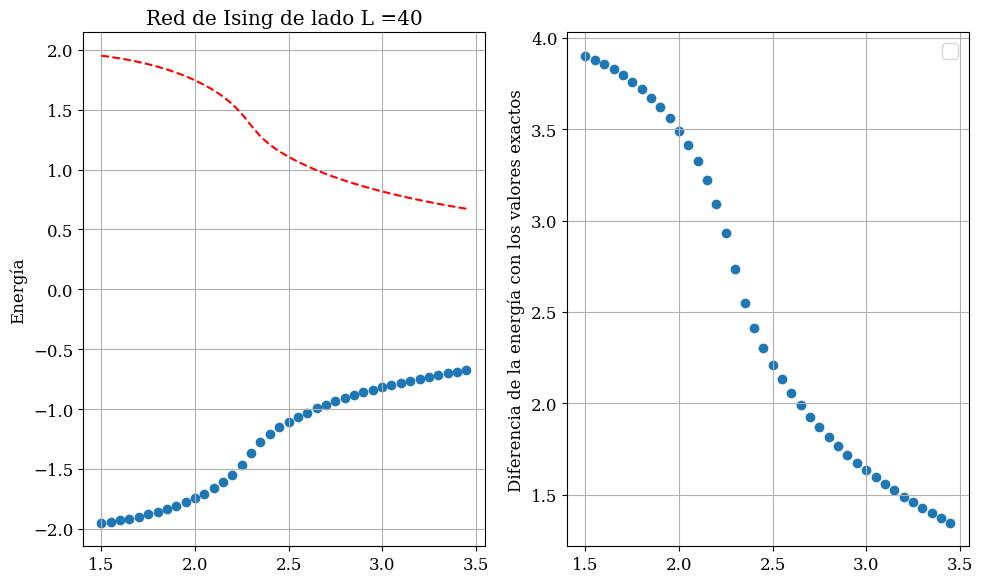

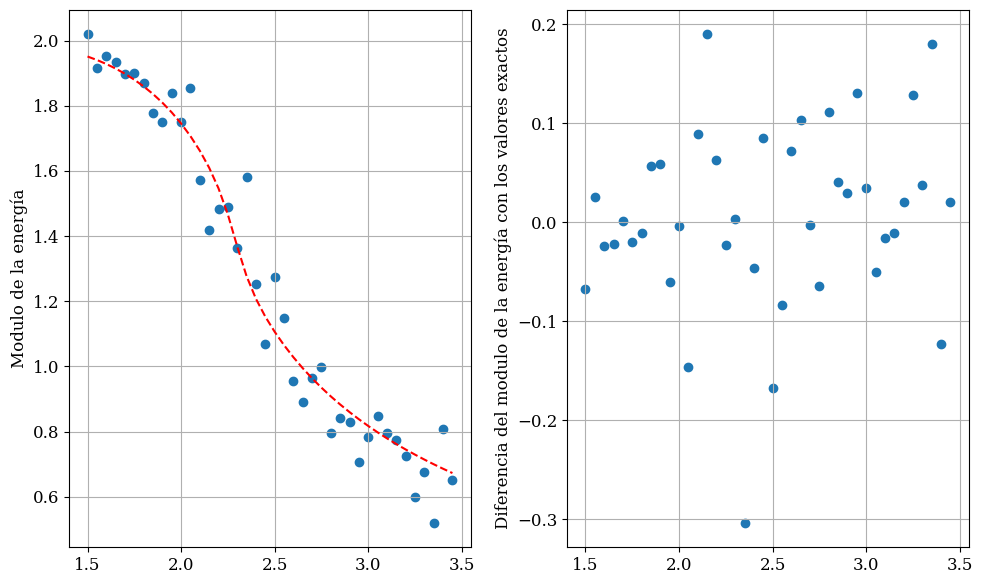

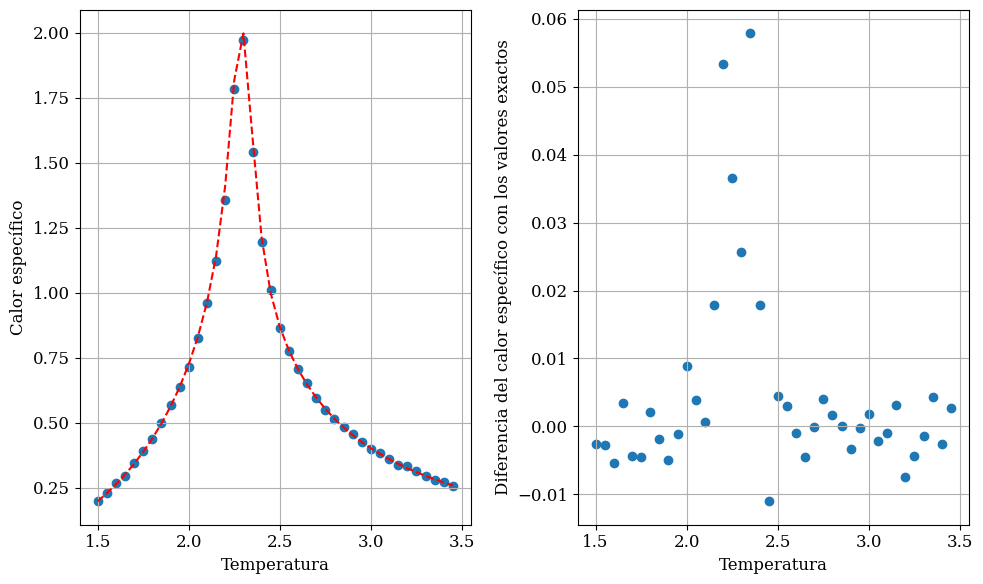

In [ ]:
UdatosExactos = pd.read_csv('U_40x40.csv')
CdatosExactos = pd.read_csv('C_40x40.csv')

TEMP = np.array(UdatosExactos.iloc[58:139,0])
UEXACTA = np.array(UdatosExactos.iloc[58:139,1])
CEXACTO = np.array(CdatosExactos.iloc[58:139,1])

Temp=[]
Uexacta=[]
Cexacto=[]

for n in range(0, int(len(TEMP)/2)):
  TempComp = TEMP[2*n]
  Temp.append(TempComp)
  UComp = UEXACTA[2*n]
  Uexacta.append(UComp)
  CComp = CEXACTO[2*n]
  Cexacto.append(CComp)

np.array(Temp)
np.array(Uexacta)
np.array(Cexacto)

L= 40 #Lado de la red

#T =  np.concatenate((np.linspace(1.5,2,10),np.linspace(2,3,20),np.linspace(3,3.5,10)))

ENERGIA = []
MODULOENERGIA = []
CALOR_ESP = []

S=np.ones((L,L),dtype=int)

for t in tqdm(Temp):

  beta = 1/t
  prob = np.array([np.exp(-4*beta),np.exp(-8*beta)])

  e=[]
  em=[]

  e.append(h(S))
  em.append(abs(h(S)))

  nequilibrio = int(100000*(np.exp(- (1/beta - 2.5)**2 *2)) // 1) #Voy a usar como referencia la cantidad de pasos que necesitamos para alcanzar el equilibrio en el entorno de la temperatura critica. Para otras temperaturas usare menos pasos para ahorrar tiempo

  for n in range(0,nequilibrio): #Termalizamos
      S,_,de=metropolis(S,prob)

  e.append(h(S))
  em.append(abs(h(S)))

  lim = nequilibrio

  for n in range(0,lim):
    S,_,de=metropolis(S,prob)
    e.append(e[-1]+de)
    em.append(em[-1]+de)

  E = np.mean(e[-lim:])
  EM = np.mean(em[-lim:])
  C = np.var(e[-lim:])*beta**2*S.size

  ENERGIA.append(E)
  MODULOENERGIA.append(EM)
  CALOR_ESP.append(C)

diferenciaU = []
diferenciaMU = []
diferenciaC = []

for u in range(0, len(Temp)):
  diferenciaU.append(Uexacta[u] - ENERGIA[u])
  diferenciaMU.append(Uexacta[u] - MODULOENERGIA[u])
  diferenciaC.append(Cexacto[u] - CALOR_ESP[u])

plt.subplot(1,2,1)
plt.plot(Temp, Uexacta, 'r--', label='Valores exactos')
plt.scatter(Temp, ENERGIA, label='Datos autogenerados')
plt.ylabel('Energía')
plt.title(f'Red de Ising de lado L ={L}')
plt.subplot(1,2,2)
plt.scatter(Temp, diferenciaU)
plt.ylabel('Diferencia de la energía con los valores exactos')
plt.legend(fontsize=15)
plt.show()

plt.subplot(1,2,1)
plt.plot(Temp, Uexacta, 'r--', label='Valores exactos')
plt.scatter(Temp, MODULOENERGIA)
plt.ylabel('Modulo de la energía')
plt.subplot(1,2,2)
plt.scatter(Temp, diferenciaMU)
plt.ylabel('Diferencia del modulo de la energía con los valores exactos')
plt.show()

plt.subplot(1,2,1)
plt.plot(Temp, Cexacto, 'r--')
plt.scatter(Temp, CALOR_ESP)
plt.ylabel('Calor específico')
plt.xlabel('Temperatura')
plt.subplot(1,2,2)
plt.scatter(Temp, diferenciaC)
plt.ylabel('Diferencia del calor específico con los valores exactos')
plt.xlabel('Temperatura')
plt.show()

# Correlaciones

La **función de correlación** se define como $g(r)=\langle s_{ij}s_{ij+r}\rangle-\langle s_{ij}\rangle\langle s_{ij+r}\rangle$, y se sabe que tiene la forma $g(r)=ae^{-r/\xi}$. A $\xi$ se lo conoce como la **longitud de correlación**, y es una función de la temperatura que, en el límite termodinámico, diverge a la temperatura crítica. El objetivo de esta sección es ver eso.

Lo primero que hay que hacer es definir dos funciones. La primera, **`cor(S)`**, devuelve un vector $c$ de $L/2$ componentes, donde $L$ es el lado de la red, cuya componente $r$ es el promedio de $s_{ij}s_{ij+r}$ sobre toda la red, es decir,

$c(r)=\frac{1}{L^2}\sum_{i,j=1}^Ls_{ij}s_{ij+r}.$

La segunda función, **`metropolis2(S,prob)`**, implementa el algoritmo de Metropolis, igual que hacía la función **`metropolis(S,prob)`**, pero esta vez, en lugar de devolver el nuevo estado, el incremento de la magnetización y el incremento de energía, devuelve el nuevo estado, el incremento de la magnetización y el incremento del vector $c$. Para definir estas dos funciones deberán prestar mucha atención a las condiciones de contorno periódicas, y tener en cuenta que $c(0)=1$ independientemente del estado, así que el incremento de $c(0)$ siempre es $0$.

In [ ]:
@njit
def cor(S):
    L = S.shape[0]
    c = np.zeros(L // 2)

    for r in range(1,L // 2):
        sum_sij_sijr = 0
        for i in range(L):
            for j in range(L):
                #sum_sij_sijr += S[i, j] * S[(i + r) % L, j]
                sum_sij_sijr += S[i, j] * S[i, (j + r) % L]

        c[r] = sum_sij_sijr / (L**2)

    c[0] = 1  # c(0) siempre es 1
    return c


@njit
def metropolis2(S, prob):
    L = S.shape[0]

    dm = 0
    dc = np.zeros(L // 2)

    Cord_ss = np.random.randint(low=0, high=L,size = (S.size,2))
    Cord_ss = Cord_ss - np.full((S.size, 2), 1) #Generamos un vector que selecciona coordenadas random de S

    for cord_ss in Cord_ss: #Aplicamos el algoritmo L veces

      ss = S[cord_ss[0], cord_ss[1]] #Seleccionamos el spin

      d_e = 2*ss*(S[cord_ss[0]-1,cord_ss[1]] + S[cord_ss[0],cord_ss[1]-1] + S[cord_ss[0]+1,cord_ss[1]] + S[cord_ss[0],cord_ss[1]+1]) #Calculamos el efecto en la energía de dar vuelta el spin

      p = 0

      if d_e == 4:
        p = prob[0]
      elif d_e == 8:
        p = prob[1]

      if d_e <= 0 or np.random.rand() < p:

        S[cord_ss[0], cord_ss[1]] = -ss
        d_m = -2 * ss / S.size
        d_e /= S.size

        for r in range(1,L // 2):
          # Recalcular el vector c
          #d_cr = 0  # Aseguramos que el incremento de c(0) sea 0
          d_cr = - (2/L**2) * ss * S[cord_ss[0], (cord_ss[1] + r) % L ] #Calculamos el efecto en c de dar vuelta el spin
          dc[r] += d_cr
          d_cr = - (2/L**2) * ss * S[cord_ss[0], (cord_ss[1] - r) % L ]
          dc[r] += d_cr
          #d_cr = - (2/L**2) * ss * S[(cord_ss[0] + r) % L, cord_ss[1] ]
          #dc[r] += d_cr

      else:
          d_m = 0
          d_e = 0

      dm += d_m
      dc[0] = 0

    return S, dm, dc


En esta parte se define la función **cor(S)**, siguiendo la ecuación $c(r)=\frac{1}{L^2}\sum_{i,j=1}^Ls_{ij}s_{ij+r},$ que devuelve un vector de $\frac{L}{2}$ componentes donde la componente r-ésima contiene el valor de la ecuación mencionada. También se pide que el valor de la primer componente sea 1.

Después se define también la función **metrópolis2** que aplica el algoritmo metrópolis $L^{2}$ veces, como la anterior. En este caso se calcula la diferencia de magnetización por cada paso y la diferencia de la función $c(r)$. Por último, esta función devuelve la nueva matriz S, la diferencia de magnetización y de $c(r)$

Ahora usamos las funciones que acabamos de definir para calcular la función de correlación a temperaturas distintas. Ajustamos los datos obtenidos con una función de la forma $a e^{-r/\xi}$, y de ahí obtenemos la longitud de correlación para esas temperaturas.

Longitud de correlacion:
T=1.5 => 0.43607504079680987 ± 0.002660752670320572
T=1.6 => 0.49413357823945264 ± 0.001975684422551155
T=1.7000000000000002 => 0.5519120852501487 ± 0.002423217694360687
T=1.8000000000000003 => 0.6414060131493958 ± 0.0049059146741195206
T=1.9000000000000004 => 0.7454043874479632 ± 0.007683530340680038
T=2.0000000000000004 => 0.9153222463597822 ± 0.015559675120305396
T=2.1000000000000005 => 1.2063237556974453 ± 0.03591832413325682
T=2.15 => 1.4672282740271865 ± 0.05585058410950346
T=2.1999999999999997 => 2.0106390998907226 ± 0.11508090545785415
T=2.2499999999999996 => 2.573222046825564 ± 0.15049857371683203
T=2.2999999999999994 => 3.5378104270243145 ± 0.19099409683081262
T=2.349999999999999 => 3.5000168762107156 ± 0.1364701078776757
T=2.399999999999999 => 3.152133142440601 ± 0.08982153347458727
T=2.449999999999999 => 2.7441605543405805 ± 0.07126694848647734
T=2.4999999999999987 => 2.4657819542319 ± 0.07180720194874356
T=2.6 => 2.0978690639069177 ± 0.066312060152

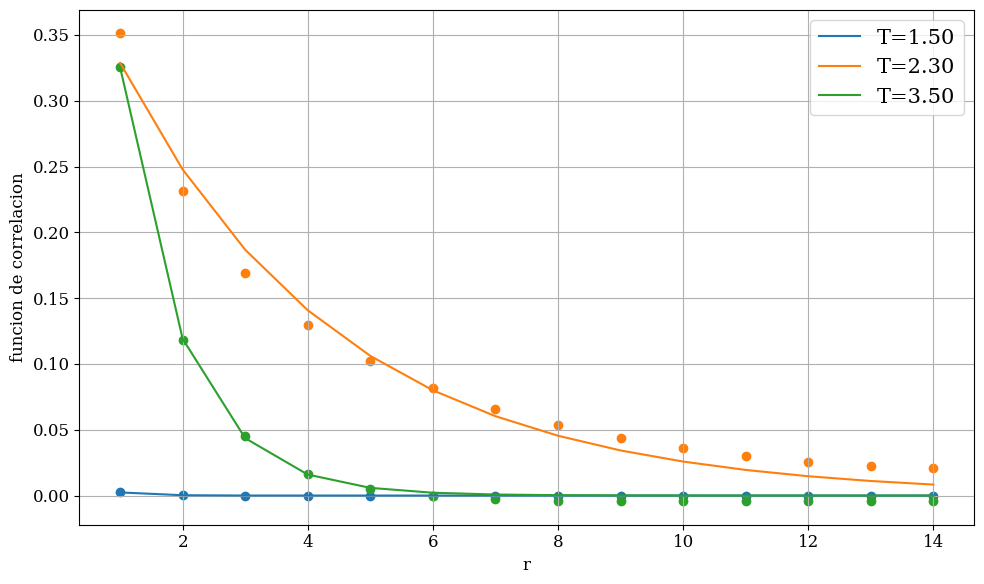

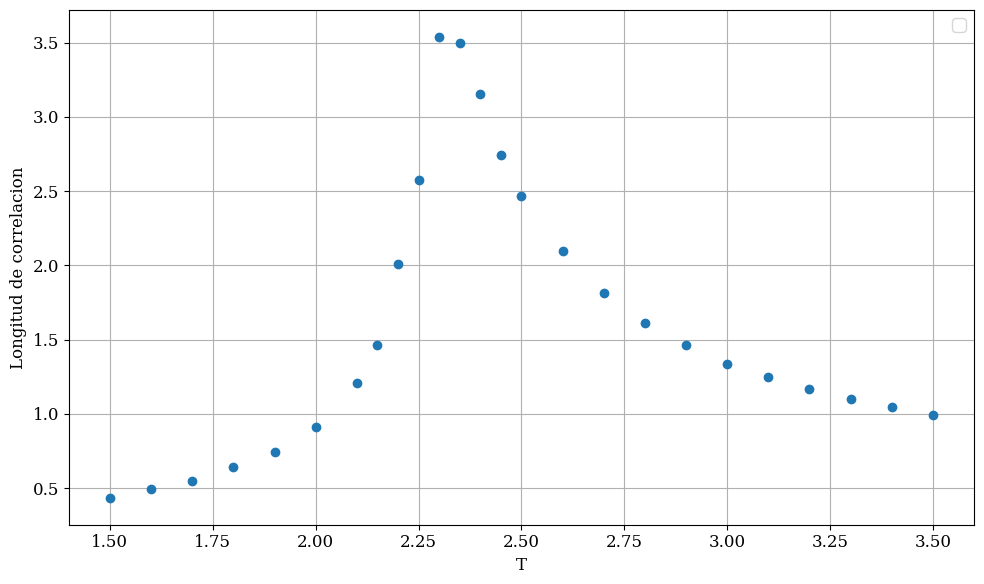

In [ ]:
L=30

npromedio=200000

l=int(L/2) #numero de componentes del vector c
m=np.zeros(npromedio) #magnetizacion en funcion del paso
c=np.zeros((l,npromedio)) #vector c en funcion del paso

erres=np.arange(l) #dominio de la funcion de correlacion

def fitcor(r,a,xi): #funcion con la que vamos a ajustar
  return np.exp(-r/xi)*a

S=np.ones((L,L),dtype=int)

print('Longitud de correlacion:')

t = np.concatenate( (np.arange(1.5,2.1,0.1), np.arange(2.15,2.5,0.05), np.arange(2.6,3.6,0.1)))
long_corr = []

for T in t:

    beta = 1/T

    nequilibrio = int(150000*(np.exp(- (1/beta - 2.3)**2 / 1.5**2)) // 1)

    prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

    #Termalizamos con la funcion metropolis(S,prob), que es mas rapida
    for n in range(nequilibrio):
        S,dm,de=metropolis(S,prob)

    m[0]=np.mean(S)
    c[:,0]=cor(S)
    for n in range(1,npromedio):
        S,dm,dc=metropolis2(S,prob)
        m[n]=m[n-1]+dm
        c[:,n]=c[:,n-1]+dc

    mmedia=np.mean(abs(m))
    correlacion=np.mean(c,axis=1)-mmedia**2 #funcion de correlacion

    #Ajustamos:
    parametros,covarianza=curve_fit(fitcor,erres[1:],correlacion[1:], maxfev=1000000)
    #(la funcion curve_fit devuelve el mejor valor de los parametros
    #y tambien la covarianza, que no vamos a usar)
    long_corr.append(parametros[1])
    errores_long_corr = np.sqrt(np.diag(covarianza)[1])

    print('T={} => {} ± {}'.format(T,parametros[1],errores_long_corr))

    if np.abs(T-1.5)<0.01 or np.abs(T-2.3)<0.01 or np.abs(T-3.5)<0.01:
      plt.plot(erres[1:],fitcor(erres[1:], *parametros),label='T={:.2f}'.format(T))
      plt.scatter(erres[1:], correlacion[1:])


plt.xlabel('r')
plt.ylabel('funcion de correlacion')
plt.legend(fontsize=15)
plt.show()

plt.errorbar(t,long_corr,yerr=errores_long_corr,fmt='o')
plt.xlabel('T')
plt.ylabel('Longitud de correlacion')
plt.legend()
plt.show()

Por último, hay que barrer un rango de temperaturas que incluya la crítica y obtener un gráfico de la longitud de correlación en función de la temperatura.

Aquí hay un gráfico típico:

![longitud_de_correlacion](http://materias.df.uba.ar/ft3a2024c1/files/2024/06/corr.png)

Una vez, obtenidas las longitudes de correlación a partir del ajuste mencionado más arriba, se las graficó en función de la temperatura.

# Temperatura crítica

La teoría de **finite-size scaling** (Fisher y Barber, Physical Review Letters **28**, 1972) muestra que, para una red de Ising bidimensional de lado $L$, el pico de la susceptibilidad ocurre a una temperatura $T_c(L)$ dada por

$$T_c(L)=T_c+\frac{a}{L},$$

donde $T_c$ es la temperatura crítica del sistema en el límite termodinámico y $a$ es una constante. Lo que deben hacer en esta sección es determinar $T_c(L)$ para $L=15,30,60,120$ con una precisión aproximada de $0.01$, graficar en función de $1/L$, ajustar los puntos a una recta y de ahí obtener una estimación para la temperatura crítica.

La figura de abajo muestra resultados para la susceptibilidad de una red de 30x30. Noten que para elegir el pico de la susceptibilidad no es una buena idea quedarse con el punto experimental más alto, porque hay bastante ruido. Ajusten una cuadrática cerca del máximo y busquen el máximo de la cuadrática. De ahí también van a poder obtener barras de error para hacer el ajuste lineal de $T_c$ y dar también un error.

![](http://materias.df.uba.ar/ft3a2024c1/files/2024/06/30x30.png)

Cuando entreguen el notebook completo, agreguen los 4 gráficos correspondientes con las parábolas ajustadas y los datos de los máximos y del error.

Estén preparados para tener que tomar muchísimos pasos para calcular promedios en la red de 120x120. En general, empiecen haciendo mediciones espaciadas y con pocos pasos para estimar la posición del máximo y luego refinen las mediciones, con más pasos y menos amplitud de temperaturas.

Abajo se muestra un ajuste típico para encontrar $T_c$.

![picture](http://materias.df.uba.ar/ft3a2024c1/files/2024/06/ajuste.png)


In [ ]:
def Plot_Tc(L,T_min,T_max,puntos,pasos):

    T =  np.linspace(T_min,T_max,puntos)

    MAGNETIZACION = []
    ENERGIA = []
    CALOR_ESP = []
    SUCEPTIBILIDAD = []
     #Numero de pasos tentativo para llegar al equilibrio

    S=np.ones((L,L),dtype=int)

    for i,beta in tqdm(enumerate(1/T)):

      prob = np.array([np.exp(-4*beta),np.exp(-8*beta)])

      intentos=[1]

      m=[]
      e=[]

      np.random.seed(0)

      nequilibrio = int((pasos)//((i+1)**2))

      for n in range(0,nequilibrio): #Termalizamos
          S,dm,de=metropolis(S,prob)

      m=[np.mean(S)]

      lim = pasos

      for n in range(0,lim):
        S,dm,de=metropolis(S,prob)
        m.append(m[-1]+dm)

      X = np.var(np.abs(m[-lim:]))*beta*S.size

      SUCEPTIBILIDAD.append(X)

    SUCEPTIBILIDAD = np.array(SUCEPTIBILIDAD)

    def fit_x2(x,a,b,c):
      return a*x**2 + b*x + c

    parametros,covarianza = curve_fit(fit_x2,T,SUCEPTIBILIDAD)

    max = -parametros[1]/(parametros[0]*2)

    error = max*np.sqrt(np.diag(covarianza)[1]/parametros[1]**2
                  + np.diag(covarianza)[0]/parametros[0]**2
                  - 2*covarianza[1,0]/(parametros[0]*parametros[1]))



    plt.scatter(T, SUCEPTIBILIDAD)

    T_range = np.linspace(T_min,T_max,300)
    plt. plot (T_range,(parametros[0]*T_range**2 + parametros[1]*T_range + parametros[2]))
    plt.vlines(max, SUCEPTIBILIDAD.min(), SUCEPTIBILIDAD.max(), linestyles='dashdot', label = 'Tc max')

    plt.title(f'Ajuste Tc para red de L={L}')
    plt.legend()
    plt.ylabel('Susceptibilidad')
    plt.xlabel('Temperatura')
    plt.show()

    print(f"La temperatura critica es {max:,.3f} \u00B1 {error:,.3f}")

L=15

30it [03:50,  7.68s/it]


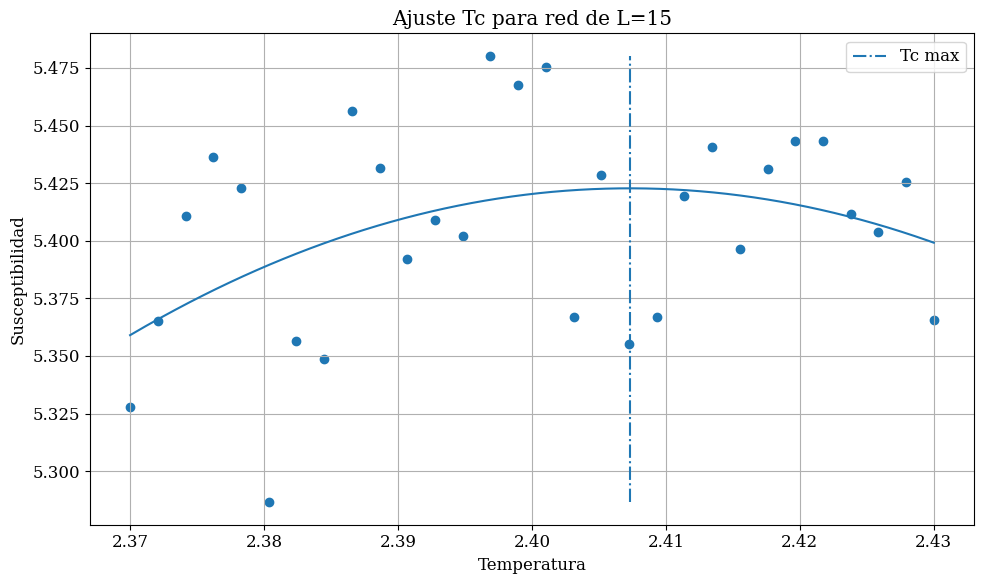

La temperatura critica es 2.407 ± 0.006


In [ ]:
Plot_Tc(15,2.37,2.43,30,300000)

L=30

30it [14:42, 29.42s/it]


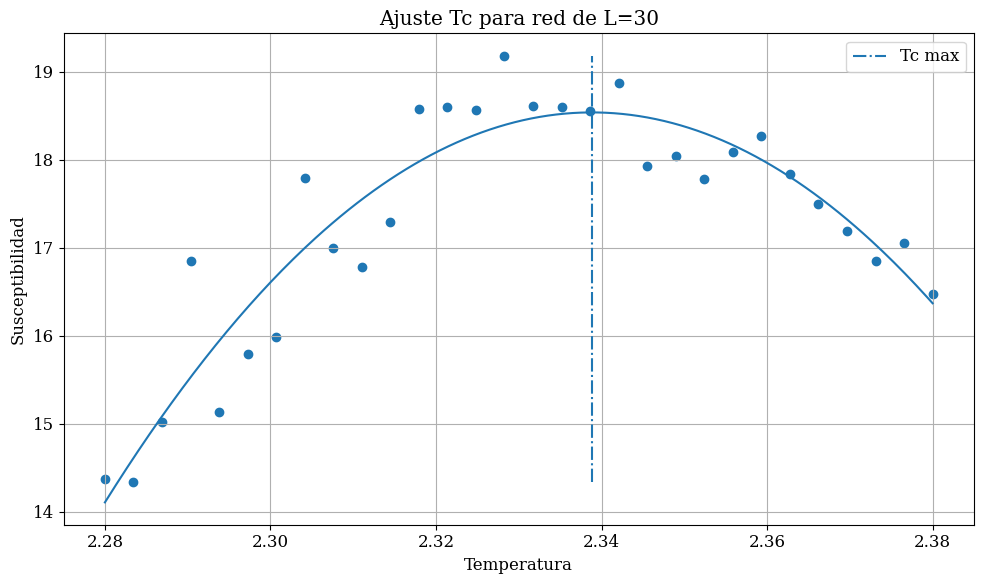

La temperatura critica es 2.339 ± 0.001


In [ ]:
Plot_Tc(30,2.28,2.38,30,300000)

L = 60

30it [19:32, 39.09s/it]


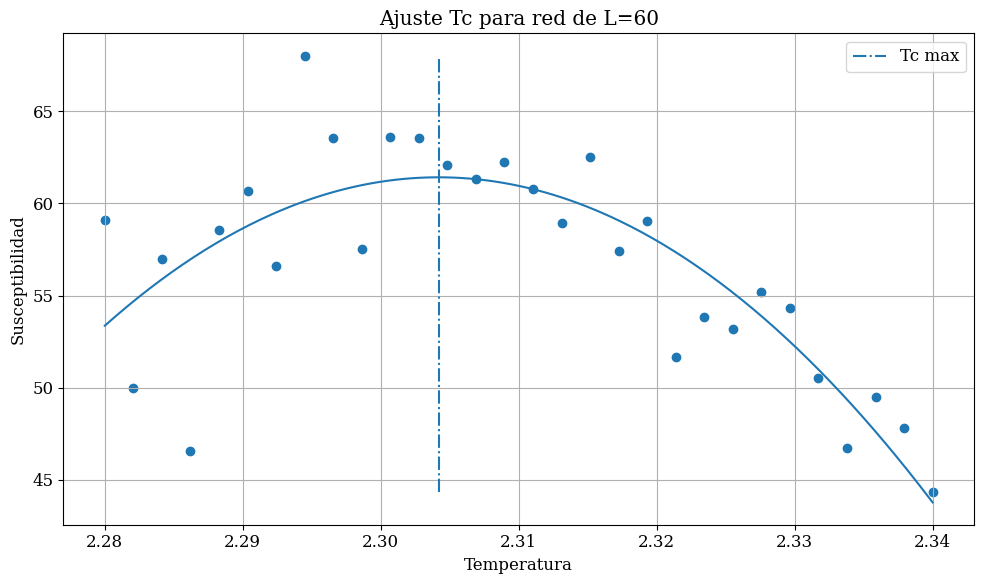

La temperatura critica es 2.304 ± 0.002


In [ ]:
Plot_Tc(60,2.28,2.34,30,100000)

L = 120

30it [1:19:52, 159.75s/it]


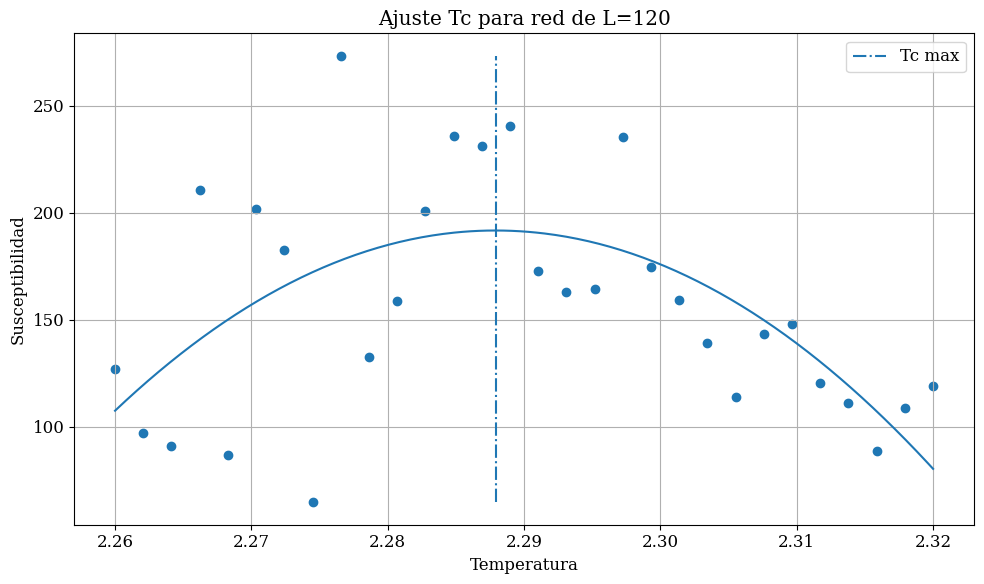

La temperatura critica es 2.288 ± 0.002


In [ ]:
Plot_Tc(120,2.26,2.32,30, 100000)

$T_{c}(L)$ ajuste

2.2704776357628584
0.0006180117031619706


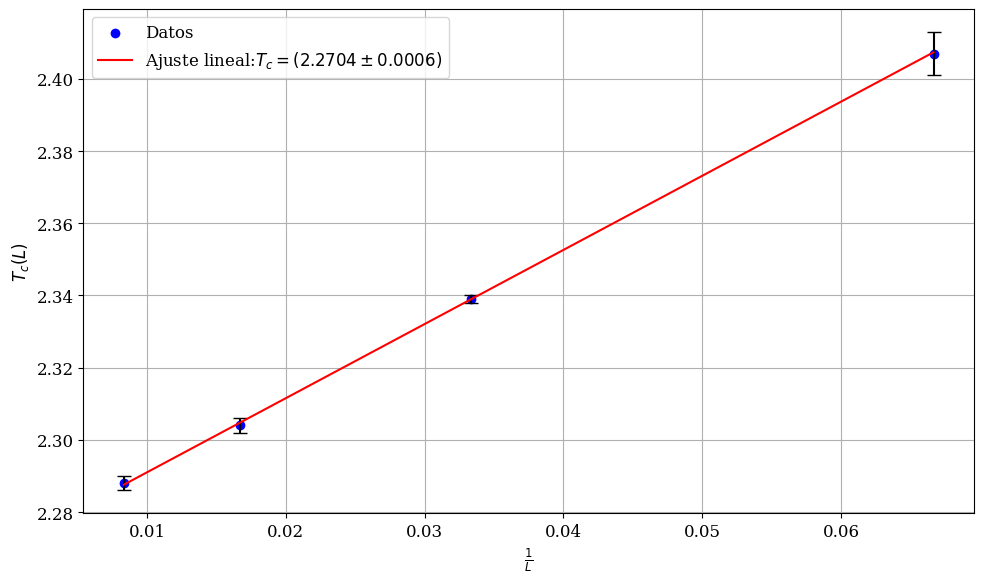

In [ ]:
TC = np.array([2.288,2.304,2.339,2.407])
DTC = np.array([0.002,0.002,0.001,0.006])
L_ = np.array([1/120,1/60,1/30,1/15])

def tc(x,a,b):
  return a*x + b

popt, pcov = curve_fit(tc,L_,TC, maxfev=1000000, sigma=DTC)

a = popt[0]
b = popt[1]

da = np.sqrt(pcov[0,0])
db = np.sqrt(pcov[1,1])

plt.errorbar(L_,TC,yerr=DTC,fmt='none', capsize=5, color='black')
plt.scatter(L_,TC,color='blue', label='Datos')
plt.plot(L_,tc(L_, *popt), color='red', label='Ajuste lineal:' + r'$T_{c}=(2.2704 \pm 0.0006)$')
plt.xlabel(r'$\frac{1}{L}$')
plt.ylabel(r'$T_{c}(L)$')

print(b)
print(db)
plt.legend()

Por último, para encontrar la temperatura crítica primero se realizó un ajuste de una cuadrática en una región del máximo de la susceptibilidad. Para esto se definió una función Plot_Tc que recibe como valores de entrada L (lado de la red),T_min (temperatura más chica para barrer),T_max,puntos (temperatura más alta a la que barrer),pasos (número que determina la cantidad de pasos para termalizar y calcular promedios). Una vez se determinó los maximos de las cuadraticas del ajuste, se graficaron estos en función de 1/L y se ajustaron. Se determinó el parámetro de la ordenada al origen de $T_{c}(L)$ siguiendo la ecuación de arriba, como la temperatura crítica.
 Se determinó que $T_{c}=(2.2704 \pm 0.0006)$, que conincide con el valor mencionado arriba de todo $T\approx 2.27$